<a href="https://colab.research.google.com/github/aritrasen87/LLM_RAG_Model_Deployment/blob/main/LangGraph_07_CheckPoints_Breakpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source: https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/

**Breakpoints** are a common HIL interaction pattern, allowing the graph to
stop at specific steps and seek human approval before proceeding.

Breakpoints are built on top of LangGraph **checkpoints**, which save the graph's state after each node execution.

Checkpoints are saved in **threads** that preserve graph state and can be accessed after a graph has finished execution.

Benefits:

- Graph execution to pause at specific points
- Await human approval
- Resume execution from the last checkpoint.

In [ ]:
! pip install langgraph langchain_community --q
! pip install langchain_openai --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 537.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 804.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367

In [ ]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.graph.message import add_messages
import operator



class State(TypedDict):
    messages: Annotated[list, operator.add]

In [ ]:
def function_1(state):
    return {'messages' :  [" First Function "]}

def function_2(state):
    return {'messages' : [" 2nd Function "]}

def function_3(state):
    return {'messages' : [" 3rd Function "]}

In [ ]:
graph = StateGraph(State)
graph.add_node("step_1", function_1)
graph.add_node("step_2", function_2)
graph.add_node("step_3", function_3)
graph.add_edge(START, "step_1")
graph.add_edge("step_1", "step_2")
graph.add_edge("step_2", "step_3")
graph.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = graph.compile(checkpointer=memory, interrupt_before=["step_3"])

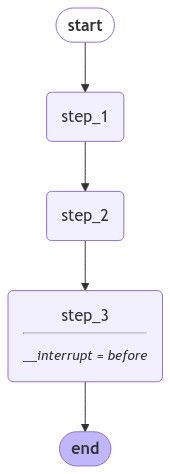

In [ ]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": ["hello langgraph"]}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'messages': ['hello langgraph']}
{'messages': ['hello langgraph', ' First Function ']}
{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ']}


In [ ]:
snapshot = graph.get_state(thread)
snapshot.next

('step_3',)

In [ ]:
thread = {"configurable": {"thread_id": "11"}}

for event in graph.stream(None, thread, stream_mode="values"):
        print(event)

EmptyInputError: Received no input for __start__

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream(None, thread, stream_mode="values"):
        print(event)

{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ']}
{'messages': ['hello langgraph', ' First Function ', ' 2nd Function ', ' 3rd Function ']}


In [ ]:
snapshot = graph.get_state(thread)
snapshot.next

()

CheckwithPoint + Breakpoint with Toolcalling

In [ ]:
! pip install langgraph-checkpoint-sqlite --q

In [ ]:
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI

# Now you can access your environment variables using os.environ
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY')

llm = ChatOpenAI(model="gpt-4o-mini")

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# memory = SqliteSaver.from_conn_string(":memory:")
# Set up memory
memory = MemorySaver()

graph = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
llm_with_tools.invoke('Hi')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 80, 'total_tokens': 90}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-9c243ba8-2f59-413d-9807-f9bdbd2a5a69-0', usage_metadata={'input_tokens': 80, 'output_tokens': 10, 'total_tokens': 90})

In [ ]:
def Agent(state: State):
    print('---> Starting Agent----->')
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=[tool])

In [ ]:
graph.add_node("Agent", Agent)
graph.add_node("tools", tool_node)

graph.add_conditional_edges(
    "Agent",
    tools_condition,
)
graph.add_edge("tools", "Agent")
graph.set_entry_point("Agent")

In [ ]:
app = graph.compile(checkpointer=memory,interrupt_before=["tools"])

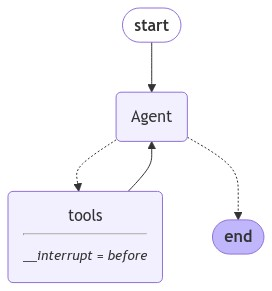

In [ ]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
# Input
input_message = {'messages':HumanMessage(content="Hello, I am Aritra , from Kolkata")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

Hello, I am Aritra , from Kolkata
None
---> Starting Agent----->
================================== Ai Message ==================================

Hello Aritra! How can I assist you today?
None


In [ ]:
# Input
input_message = {'messages':HumanMessage(content="Sorry where I am from?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

Sorry where I am from?
None
---> Starting Agent----->
================================== Ai Message ==================================

You're from Kolkata. If you have any specific questions or topics you'd like to discuss about Kolkata or anything else, feel free to let me know!
None


In [ ]:
# Input
input_message = {'messages':HumanMessage(content="What is there weather there?")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

What is there weather there?
None
---> Starting Agent----->
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_p5UbmJU1mFB0kUoDpb3kO2JT)
 Call ID: call_p5UbmJU1mFB0kUoDpb3kO2JT
  Args:
    query: Kolkata current weather
None


In [ ]:
# Run the graph until the first interruption
for event in app.stream(None, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_p5UbmJU1mFB0kUoDpb3kO2JT)
 Call ID: call_p5UbmJU1mFB0kUoDpb3kO2JT
  Args:
    query: Kolkata current weather
None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Kolkata', 'region': 'West Bengal', 'country': 'India', 'lat': 22.57, 'lon': 88.37, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1725888381, 'localtime': '2024-09-09 18:56'}, 'current': {'last_updated_epoch': 1725887700, 'last_updated': '2024-09-09 18:45', 'temp_c': 29.2, 'temp_f': 84.6, 'is_day': 0, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/night/143.png', 'code': 1030}, 'wind_mph': 6.9, 'wind_kph': 11.2, 'wind_degree': 120, 'wind_dir': 'ESE', 'pressure_mb': 999.0, 'pressure_in': 29.5, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity'

In [ ]:
# Input
input_message = {'messages':HumanMessage(content="What are the best foods to explore there?")}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

What are the best foods to explore there?
None
---> Starting Agent----->
================================== Ai Message ==================================

Kolkata is famous for its rich culinary heritage and diverse food offerings. Here are some of the best foods to explore in Kolkata:

1. **Puchka (Pani Puri)**: A popular street snack consisting of hollow puris filled with spicy tamarind water, chickpeas, and potatoes.

2. **Kathi Rolls**: A delicious wrap made with paratha (flatbread) filled with spicy grilled meat or vegetables, often served with chutney.

3. **Macher Jhol**: A traditional Bengali fish curry made with fresh fish, vegetables, and a variety of spices, usually served with rice.

4. **Shorshe Ilish**: Hilsa fish cooked in mustard sauce, a quintessential Bengali dish enjoyed with steamed rice.

5. **Chingri Malai Curry**: A creamy prawn curry made with coconut milk and aromatic spices, serv

In [ ]:
# Input
input_message = {'messages':HumanMessage(content="Tell me about the recent protest happening there?")}

# Run the graph until the first interruption
for event in app.stream(input_message, thread, stream_mode="values"):
    print(event["messages"][-1].pretty_print())

================================ Human Message =================================

Tell me about the recent protest happening there?
None
---> Starting Agent----->
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_wCXMvCYl0uLpi6NXZoWfuSpQ)
 Call ID: call_wCXMvCYl0uLpi6NXZoWfuSpQ
  Args:
    query: recent protests in Kolkata September 2024
None


In [ ]:
snapshot = app.get_state(thread)
current_message = snapshot.values["messages"][-1]
current_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_wCXMvCYl0uLpi6NXZoWfuSpQ)
 Call ID: call_wCXMvCYl0uLpi6NXZoWfuSpQ
  Args:
    query: recent protests in Kolkata September 2024


In [ ]:
tool_call_id = current_message.tool_calls[0]["id"]
tool_call_id

'call_wCXMvCYl0uLpi6NXZoWfuSpQ'

In [37]:
from langchain_core.messages import AIMessage, ToolMessage

answer = """The protest is about an unfortune incident with a lady Doctor in R.G.Kar hospital in Kolkata, as a protest against the adiministration.
People are using a slogan - "#WeWantJustice"! """
new_messages = [
    ToolMessage(content=answer, tool_call_id=tool_call_id),
    AIMessage(content=answer),
]

In [38]:
app.update_state(
    thread,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6eb0c-dd6d-68a6-8012-b6d0136bdbd4'}}

In [39]:
print(app.get_state(thread).values["messages"][-1:])

[AIMessage(content='The protest is about an unfortune incident with a lady Doctor in R.G.Kar hospital in Kolkata, as a protest against the adiministration.\nPeople are using a slogan - "#WeWantJustice"! ', id='169d57de-7452-4398-8833-a387b7e53e97')]
